In [1]:
import pandas as pd
#import numpy as np

import seaborn as sns
import matplotlib.pyplot as plt
#plt.style.use('dark_background')

# Introduction
***

<center> 

![meli.png](meli.png) 

</center>

#### Determine if a user of MercadoPago (MP) Argentina will make transactions again in the next 2 months.

***
# Pre-Processing
***

## Evaluate

EVALUATE.csv is the dataset used to train and evaluate the model.

In [2]:
# Load dataset: EVALUATE.csv
evaluate = pd.read_csv('Datasets_prueba/EVALUATE.csv', dtype = int)
evaluate.head()

,CUS_CUST_ID_BUY,churn
0,20663512,1
1,444286946,0
2,348084528,1
3,59232755,1
4,168821213,1


[Text(0.5, 0, 'churn'),
 Text(0, 0.5, 'nº observatios'),
 Text(0.5, 1.0, 'Unbalanced classes')]

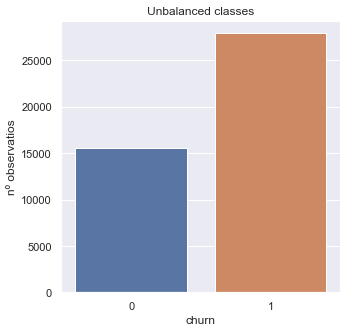

In [3]:
# Unbalanced classes
sns.set(rc={'figure.figsize':(5 , 5)})
ax = sns.barplot(x="churn",
                 y="CUS_CUST_ID_BUY",
                 data= evaluate.groupby('churn', as_index = False).count())
ax.set(xlabel='churn',
       ylabel='nº observatios',
       title = 'Unbalanced classes')

## Active User

Contains data on visits to the APP.

- CUS_CUST_ID_BUY: Buyer ID.
- MAU_MP_1: Number of times the user entered the MP APP (blue) in the last month of training (month -1).
- MAU_ML_1: Number of times the user entered the ML APP (yellow) in the last month of training (month -1).
- MAU_ML_2: Number of times the user entered the ML APP (yellow) in month -2 of training.
- last_login_mp_date_1: Date of the last login of the month in APP MP.


In [4]:
evaluate = pd.merge(left = evaluate, right = pd.read_csv('Datasets_prueba/ACTIVE_USER.csv'),
                    on = 'CUS_CUST_ID_BUY',
                    how = 'left',
                    validate='one_to_one')

In [5]:
# From the last_login_mp_date_1 and last_login_ml_date_1 columns, only the day is taken
names = ['last_login_mp_date_1', 'last_login_ml_date_1']

for name in names:
    evaluate[name] = [x.day for x in pd.to_datetime(evaluate[name], errors='ignore')]

With the last_login_ml_day_1 and last_login_mp_day_1 columns, classes are created separating the month in 3:
     
* 1-10: 1 
* 11-20: 2 
* 21-31: 3 
* Nan: 0 - no connection
    

In [6]:
names = ['last_login_mp_date_1', 'last_login_ml_date_1']

for name in names:
    name_c = name + '_c'
    
    evaluate.loc[(evaluate[name] >= 1) & (evaluate[name] <= 10), name_c] = 1
    evaluate.loc[(evaluate[name] >= 11) & (evaluate[name] <= 20), name_c] = 2
    evaluate.loc[(evaluate[name] >= 21) & (evaluate[name] <= 31), name_c] = 3
    
    evaluate[name_c] = pd.factorize(evaluate[name_c], sort = True)[0]
    
    evaluate[name_c] = evaluate[name_c] + 1 

# Se eliminan las columnas categorizadas
evaluate.drop(columns = names, inplace= True)

In [7]:
evaluate.head()

,CUS_CUST_ID_BUY,churn,MAU_MP_3,MAU_ML_3,MAU_MP_2,MAU_ML_2,MAU_MP_1,MAU_ML_1,last_login_mp_date_1_c,last_login_ml_date_1_c
0,20663512,1,13.0,25.0,14.0,24.0,5.0,25.0,3,3
1,444286946,0,NaN,NaN,NaN,NaN,NaN,NaN,0,0
2,348084528,1,4.0,4.0,4.0,3.0,3.0,8.0,3,3
3,59232755,1,0.0,28.0,0.0,25.0,0.0,18.0,3,3
4,168821213,1,0.0,21.0,4.0,13.0,6.0,18.0,3,3


## Demograficos

Contains data on age, sex, card used and place of residence.

In [8]:
evaluate = pd.merge(left = evaluate, right = pd.read_csv('Datasets_prueba/DEMOGRAFICOS.csv'),
                      on = 'CUS_CUST_ID_BUY',
                      how = 'left',
                      validate='one_to_one')

In [9]:
# Missing data is completed as observed in the data
evaluate['GENDER'] = pd.factorize(evaluate['GENDER'].fillna('Unknown'),sort = True)[0]
evaluate['RANGO_EDAD'] = pd.factorize(evaluate['RANGO_EDAD'].fillna('00. Sin Dato'),
                                      sort = True)[0]

# Missing data is completed with 'Sin Dato'
evaluate[['CITY', 'TARJETAS', 'ESTADO']] = evaluate[['CITY',
                                                     'TARJETAS',
                                                     'ESTADO']].fillna('0. Sin Dato')

# Factorize data
for col in ['CITY', 'GENDER', 'TARJETAS', 'ESTADO']:
    evaluate[col] = pd.factorize(evaluate[col], sort = True)[0]
    
evaluate.head()

,CUS_CUST_ID_BUY,churn,MAU_MP_3,MAU_ML_3,MAU_MP_2,MAU_ML_2,MAU_MP_1,MAU_ML_1,last_login_mp_date_1_c,last_login_ml_date_1_c,CITY,GENDER,RANGO_EDAD,TARJETAS,ESTADO
0,20663512,1,13.0,25.0,14.0,24.0,5.0,25.0,3,3,2953,1,6,4,5
1,444286946,0,NaN,NaN,NaN,NaN,NaN,NaN,0,0,223,2,3,5,5
2,348084528,1,4.0,4.0,4.0,3.0,3.0,8.0,3,3,2063,1,0,4,29
3,59232755,1,0.0,28.0,0.0,25.0,0.0,18.0,3,3,946,2,4,5,3
4,168821213,1,0.0,21.0,4.0,13.0,6.0,18.0,3,3,1416,1,0,4,3


## Dinero Cuenta

It contains data of the amount of money in the account and if it invests in the fund.

- PLATA_CUENTA_1: Maximum money in the account in the last month (month -1).
- PLATA_CUENTA_2: Maximum money in account in month -2.
- INVERSION: Indicates in which state the user is for the investment:
    - Investing: You are investing.
    - Elegible: It is available for you to invest money.
    - Warmup: They did the investment onboarding but did not fill in the fields.
    - Pending: They made the process to invest, it is pending approval.

In [10]:
evaluate = pd.merge(left = evaluate, right = pd.read_csv('Datasets_prueba/DINERO_CUENTA.csv'),
                      on = 'CUS_CUST_ID_BUY',
                      how = 'left',
                      validate='one_to_one')

In [11]:
# Missing data is completed with '0. Sin Dato'
evaluate[['INVERSION']] = evaluate[['INVERSION']].fillna('0. Sin Dato')

# Factorize data
evaluate['INVERSION'] = pd.factorize(evaluate['INVERSION'], sort = True)[0]
evaluate.head()

,CUS_CUST_ID_BUY,churn,MAU_MP_3,MAU_ML_3,MAU_MP_2,MAU_ML_2,MAU_MP_1,MAU_ML_1,last_login_mp_date_1_c,last_login_ml_date_1_c,CITY,GENDER,RANGO_EDAD,TARJETAS,ESTADO,PLATA_CUENTA_1,PLATA_CUENTA_2,INVERSION
0,20663512,1,13.0,25.0,14.0,24.0,5.0,25.0,3,3,2953,1,6,4,5,6935.65,10447.87,5
1,444286946,0,NaN,NaN,NaN,NaN,NaN,NaN,0,0,223,2,3,5,5,NaN,NaN,0
2,348084528,1,4.0,4.0,4.0,3.0,3.0,8.0,3,3,2063,1,0,4,29,0.00,0.00,4
3,59232755,1,0.0,28.0,0.0,25.0,0.0,18.0,3,3,946,2,4,5,3,0.00,0.00,4
4,168821213,1,0.0,21.0,4.0,13.0,6.0,18.0,3,3,1416,1,0,4,3,0.00,0.00,4


## Marketplace data

Contains a user-level summary of movements in MercadoLibre (ML) for the last 6 months.
- SPENT_ML: Money spent in ML.
- RECENCY_ML: Date of the last purchase in ML.
- FREQUENCY_ML: Number of days you made purchases.

In [12]:
evaluate = pd.merge(left = evaluate, right = pd.read_csv('Datasets_prueba/MARKETPLACE_DATA.csv'),
                      on = 'CUS_CUST_ID_BUY',
                      how = 'left',
                      validate='one_to_one')

In [13]:
# str to datetime
evaluate['RECENCY_ML'] = pd.to_datetime(evaluate['RECENCY_ML'], errors='ignore')

# The date of the last purchase is used to calculate the days elapsed
def f1(x):
    return (x.day + ((6 - x.month) * 30) + ((2019 - x.year) * 365))

evaluate['days_since_last_purchase'] = evaluate['RECENCY_ML'].apply(f1)

evaluate.drop(columns = ['RECENCY_ML'], inplace= True)

The days elapsed since the last purchase are used to create categories grouped by number of months:

* 0_ No connection: Nan
* 1_ More than two months: > 63
* 2_ Less than two months and more than one month: 32 - 62
* 3_ Less than a month: < 31 days


In [14]:
name = 'days_since_last_purchase'
name_c = name + '_c'

evaluate.loc[(evaluate[name].isna()), name_c] = 0
evaluate.loc[(evaluate[name] > 62), name_c] = 1
evaluate.loc[(evaluate[name] > 31) & (evaluate[name] <= 62), name_c] = 2
evaluate.loc[(evaluate[name] <= 31), name_c] = 3

evaluate.drop(columns = 'days_since_last_purchase', inplace= True)

# Clases como enteros
evaluate[['days_since_last_purchase_c']] = evaluate[['days_since_last_purchase_c']].astype(int)

evaluate.head()

,CUS_CUST_ID_BUY,churn,MAU_MP_3,MAU_ML_3,MAU_MP_2,MAU_ML_2,MAU_MP_1,MAU_ML_1,last_login_mp_date_1_c,last_login_ml_date_1_c,...,GENDER,RANGO_EDAD,TARJETAS,ESTADO,PLATA_CUENTA_1,PLATA_CUENTA_2,INVERSION,SPENT_ML,FREQUENCY_ML,days_since_last_purchase_c
0,20663512,1,13.0,25.0,14.0,24.0,5.0,25.0,3,3,...,1,6,4,5,6935.65,10447.87,5,1004.95,14.0,2
1,444286946,0,NaN,NaN,NaN,NaN,NaN,NaN,0,0,...,2,3,5,5,NaN,NaN,0,NaN,NaN,0
2,348084528,1,4.0,4.0,4.0,3.0,3.0,8.0,3,3,...,1,0,4,29,0.00,0.00,4,NaN,NaN,0
3,59232755,1,0.0,28.0,0.0,25.0,0.0,18.0,3,3,...,2,4,5,3,0.00,0.00,4,486.67,10.0,2
4,168821213,1,0.0,21.0,4.0,13.0,6.0,18.0,3,3,...,1,0,4,3,0.00,0.00,4,180.25,6.0,2


## Payments

Contains MP transactional data that have been carried out in the last 6 months. This is only limited to the Wallet segment (all payments made with a virtual wallet).

- FECHA: Date on which the transaction was successfully carried out.
- CUS_CUST_ID_SEL: Seller ID.
- CUS_CUST_ID_BUY: Buyer ID.
- SPENT: Money spent on the transaction.
- TPV_SEGMENT_DETAIL: Flow used by the user (Instore = QR, Transport = SUBE, Utilities = Payment of services, money transfer, Cellphone recharge).
- DESCUENTOS: Discount that MP granted you in that transaction.

In [15]:
# Load dataset: PAYMENTS.csv
payments = pd.read_csv('Datasets_prueba/PAYMENTS.csv')
payments.head()

,FECHA,CUS_CUST_ID_SEL,CUS_CUST_ID_BUY,SPENT,TPV_SEGMENT_DETAIL,DESCUENTO
0,2019-05-25,314941456,20663512,11.3566,Instore,2.2312
1,2019-06-20,251693291,444286946,4.6190,Transport,0.9238
2,2019-01-10,251693291,20663512,5.3519,Transport,1.0704
3,2019-03-28,251693291,20663512,4.5589,Transport,0.0000
4,2019-01-07,251693291,20663512,8.0278,Transport,0.0000


In [16]:
# str to datetime
payments['FECHA'] = pd.to_datetime(payments['FECHA'], errors='ignore')

payments['FECHA'] = [x.month for x in payments['FECHA']]

payments.loc[(payments['FECHA'] == 7), 'Mes1'] = 1
payments.loc[(payments['FECHA'] == 6), 'Mes2'] = 1
payments.loc[(payments['FECHA'] == 5), 'Mes3'] = 1
payments.loc[(payments['FECHA'] == 4), 'Mes4'] = 1
payments.loc[(payments['FECHA'] == 3), 'Mes5'] = 1
payments.loc[(payments['FECHA'] == 2), 'Mes6'] = 1

In [17]:
# payment discount
payments['DESCUENTO_%'] = payments['DESCUENTO'] / payments['SPENT'] 

In [18]:
# Total transactions per month in the last 6 months recorded
u_meses = payments.groupby('CUS_CUST_ID_BUY')[['Mes1', 'Mes2', 'Mes3', 'Mes4', 'Mes5', 'Mes6']].sum()

# Median of the total spent and the discount obtained
medianas = payments.groupby('CUS_CUST_ID_BUY')[['SPENT', 'DESCUENTO']].median()
desc_median = payments.groupby('CUS_CUST_ID_BUY')[['DESCUENTO_%']].median()

# used most frequently
tpv_segment = payments.groupby('CUS_CUST_ID_BUY')[['TPV_SEGMENT_DETAIL']].agg(lambda x:x.value_counts().index[0])
tpv_segment_total = payments.groupby('CUS_CUST_ID_BUY')[['TPV_SEGMENT_DETAIL']].agg(lambda x:x.value_counts().values[0])

In [19]:
u_meses['mediana_gastado'] = medianas['SPENT'].values
u_meses['mediana_descuento'] = medianas['DESCUENTO'].values
u_meses['%_descuento'] = desc_median['DESCUENTO_%'].values
u_meses['tpv_segment'] = pd.factorize(tpv_segment['TPV_SEGMENT_DETAIL'].values)[0]
u_meses['tpv_segment_frec'] = tpv_segment_total['TPV_SEGMENT_DETAIL'].values
u_meses.reset_index(inplace = True)

In [25]:
u_meses.head()

,CUS_CUST_ID_BUY,Mes1,Mes2,Mes3,Mes4,Mes5,Mes6,mediana_gastado,mediana_descuento,%_descuento,tpv_segment,tpv_segment_frec
0,1276,0.0,0.0,1.0,0.0,1.0,2.0,1.91965,0.00000,0.000000,0,4
1,14525,0.0,2.0,13.0,11.0,10.0,8.0,6.93075,0.00000,0.000000,1,46
2,21230,0.0,0.0,1.0,0.0,0.0,0.0,4.41980,2.20990,0.500000,2,1
3,22083,0.0,1.0,4.0,1.0,5.0,4.0,6.85740,0.46415,0.100003,1,12
4,23513,0.0,0.0,1.0,4.0,3.0,2.0,1.81090,0.00000,0.000000,2,7


In [20]:
evaluate = pd.merge(left = evaluate, right = u_meses,
                      on = 'CUS_CUST_ID_BUY',
                      how = 'left',
                      validate='one_to_one')

evaluate.head()

,CUS_CUST_ID_BUY,churn,MAU_MP_3,MAU_ML_3,MAU_MP_2,MAU_ML_2,MAU_MP_1,MAU_ML_1,last_login_mp_date_1_c,last_login_ml_date_1_c,...,Mes2,Mes3,Mes4,Mes5,Mes6,mediana_gastado,mediana_descuento,%_descuento,tpv_segment,tpv_segment_frec
0,20663512,1,13.0,25.0,14.0,24.0,5.0,25.0,3,3,...,2.0,1.0,2.0,2.0,1.0,9.69220,0.0000,0.000000,2,6
1,444286946,0,NaN,NaN,NaN,NaN,NaN,NaN,0,0,...,4.0,0.0,0.0,0.0,0.0,4.38515,1.2635,0.225002,1,3
2,348084528,1,4.0,4.0,4.0,3.0,3.0,8.0,3,3,...,8.0,1.0,2.0,4.0,0.0,12.23230,0.0000,0.000000,3,9
3,59232755,1,0.0,28.0,0.0,25.0,0.0,18.0,3,3,...,9.0,6.0,0.0,0.0,0.0,41.64730,0.0000,0.000000,3,9
4,168821213,1,0.0,21.0,4.0,13.0,6.0,18.0,3,3,...,6.0,4.0,5.0,1.0,0.0,2.27430,0.0000,0.000000,0,13


## Save

In [21]:
# Save
evaluate.to_csv('evaluate_jned.csv', index = False)

***
# Correlation analysis
***

Detect highly correlated descriptors(columns)

In [21]:
import pandas as pd
import numpy as np

import seaborn as sns
import matplotlib.pyplot as plt
#plt.style.use('dark_background')

In [22]:
evaluate = pd.read_csv('evaluate_jned.csv')
evaluate.head()

,CUS_CUST_ID_BUY,churn,MAU_MP_3,MAU_ML_3,MAU_MP_2,MAU_ML_2,MAU_MP_1,MAU_ML_1,last_login_mp_date_1_c,last_login_ml_date_1_c,...,Mes2,Mes3,Mes4,Mes5,Mes6,mediana_gastado,mediana_descuento,%_descuento,tpv_segment,tpv_segment_frec
0,20663512,1,13.0,25.0,14.0,24.0,5.0,25.0,3,3,...,2.0,1.0,2.0,2.0,1.0,9.69220,0.0000,0.000000,2,6
1,444286946,0,NaN,NaN,NaN,NaN,NaN,NaN,0,0,...,4.0,0.0,0.0,0.0,0.0,4.38515,1.2635,0.225002,1,3
2,348084528,1,4.0,4.0,4.0,3.0,3.0,8.0,3,3,...,8.0,1.0,2.0,4.0,0.0,12.23230,0.0000,0.000000,3,9
3,59232755,1,0.0,28.0,0.0,25.0,0.0,18.0,3,3,...,9.0,6.0,0.0,0.0,0.0,41.64730,0.0000,0.000000,3,9
4,168821213,1,0.0,21.0,4.0,13.0,6.0,18.0,3,3,...,6.0,4.0,5.0,1.0,0.0,2.27430,0.0000,0.000000,0,13


In [28]:
to_evaluate = evaluate[['MAU_MP_3', 'MAU_ML_3', 'MAU_MP_2', 'MAU_ML_2', 'MAU_MP_1', 'MAU_ML_1',
                        'PLATA_CUENTA_1', 'PLATA_CUENTA_2', 'SPENT_ML', 'FREQUENCY_ML', 
                        'Mes1', 'Mes2','Mes3', 'Mes4', 'Mes5', 'Mes6',
                        'mediana_gastado', 'mediana_descuento', '%_descuento', 'tpv_segment_frec']]

<AxesSubplot:>

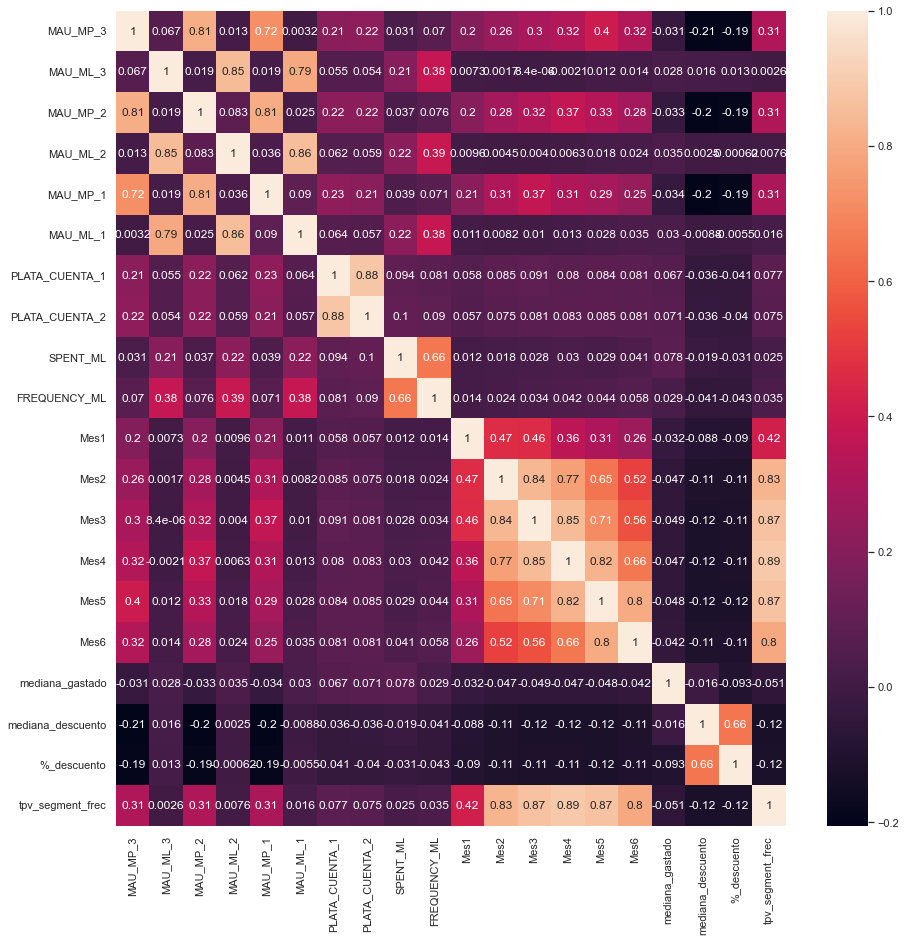

In [29]:
correlation_mat = to_evaluate.corr()

plt.figure(figsize=(15,15))
sns.heatmap(correlation_mat, annot = True)

In [24]:
evaluate.drop(columns = ['tpv_segment_frec'], inplace= True)

In [30]:
# Save
evaluate.to_csv('evaluate_jned.csv', index = False)